In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.3 MB/s eta 0:00:00


In [ ]:
pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 23.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch_geometric

print(torch.__version__)
print(torch_geometric.__version__)

2.3.0+cu121
2.5.3


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data
import os.path as osp
import os
import numpy as np
from tqdm.auto import tqdm

In [ ]:
### reading raw files from a directory.
### for homogeneous graph
def read_csv_graph_raw(raw_dir, add_inverse_edge=False):
    '''
    raw_dir: path to the raw directory
    add_inverse_edge (bool): whether to add inverse edge or not

    return: graph_list, which is a list of graphs.
    Each graph is a dictionary, containing edge_index, edge_feat, node_feat, and num_nodes
    edge_feat and node_feat are optional: if a graph does not contain it, we will have None.

    '''

    print('Loading necessary files...')
    print('This might take a while.')
    # loading necessary files
    # pandas.DataFrame.values: return a Numpy representation(numpy.ndarray) of the DataFrame. Only the values in the DataFrame will be returned, the axes labels will be removed.
    # numpy.ndarray.T: view of the transposed array. Same as self.transpose().
    try:
        edge=pd.read_csv(osp.join(raw_dir, 'edge.csv'), header=None).values.T.astype(np.int64) # (2, num_edge) numpy array
        num_node_list=pd.read_csv(osp.join(raw_dir, 'num-node-list.csv'), header=None).astype(np.int64)[0].tolist() # (num_graph, ) python list, df[0]: 0th column
        num_edge_list=pd.read_csv(osp.join(raw_dir, 'num-edge-list.csv'), header=None).astype(np.int64)[0].tolist() # (num_edge, ) python list
    except FileNotFoundError:
        raise RuntimeError('No necessary file')

    try:
        node_feat=pd.read_csv(osp.join(raw_dir, 'node-feat.csv'), header=None).values.astype(np.float32)
    except FileNotFoundError:
        node_feat=None

    try:
        edge_feat=pd.read_csv(osp.join(raw_dir, 'edge-feat.csv'), header=None).values.astype(np.float32)
    except FileNotFoundError:
        edge_feat=None


    graph_list=[]
    num_node_accum=0
    num_edge_accum=0

    # tqdm: a Python module to easily print in the console a dynamically updating progressbar.
    # tqdm can be used with 'zip' if a 'total' keyword argument is provided in the tqdm call, the issue is that tqdm needs to know the length of the iterable ahead of time.
    # Because 'zip' is meant to handle iterables with different lengths, it deos not have as an attribute a single length of its arguments.
    print('Processing graphs...')
    for num_node, num_edge in tqdm(zip(num_node_list, num_edge_list), total=len(num_node_list)):

        graph=dict()

        ### handling edge
        if add_inverse_edge:
            ### duplicate edge
            ### numpy.repeat: repeat each element of an array after themselves
            duplicated_edge=np.repeat(edge[:, num_edge_accum:num_edge_accum+num_edge], 2, axis=1) # parameters: (2, num_edge) input array, 2 repetitions for each element, column axis
            duplicated_edge[0, 1::2]=duplicated_edge[1, 0::2] # inverse start
            duplicated_edge[1, 1::2]=duplicated_edge[0, 0::2] # inverse end

            graph['edge_index']=duplicated_edge

            if edge_feat is not None:
                graph['edge_feat']=np.repeat(edge_feat[num_edge_accum:num_edge_accum+num_edge], 2, axis=0) # parameters: (num_edge, edgefeat_dim) input array, 2 repetitions for each element, row axis
            else:
                graph['edge_feat']=None
        else:
            graph['edge_index']=edge[:, num_edge_accum:num_edge_accum+num_edge]

            if edge_feat is not None:
                graph['edge_feat']=edge_feat[num_edge_accum:num_edge_accum+num_edge]
            else:
                graph['edge_feat']=None

        num_edge_accum+=num_edge

        ### handling node
        if node_feat is not None:
            graph['node_feat']=node_feat[num_node_accum:num_node_accum+num_node]
        else:
            graph['node_feat']=None


        graph['num_nodes']=num_node
        num_node_accum+=num_node

        graph_list.append(graph)

    return graph_list

In [ ]:
def read_graph_pyg(raw_dir, add_inverse_edge=False):
    # csv
    graph_list=read_csv_graph_raw(raw_dir, add_inverse_edge)

    pyg_graph_list=[]

    print('Converting graphs into PyG objects...')

    # Data(): a data object describing a homogeneous graph. The data object can hold node-level, link-level and graph-level attributes.
    # x - Node feature matrix with shape [num_nodes, num_node_features].
    # edge_index - Graph connectivity in COO format with shape [2, num_edges].
    # edge_attr - Edge feature matrix with shape [num_edges, num_edge_features].
    # y - Graph-level or node-level ground-truth labels with arbitrary shape.
    for graph in tqdm(graph_list):
        g=Data()
        g.num_nodes=graph['num_nodes']
        g.edge_index=torch.from_numpy(graph['edge_index']) # torch.from_numpy: creates a Tensor from a numpy.ndarray

        del graph['num_nodes']
        del graph['edge_index']

        if graph['edge_feat'] is not None:
            g.edge_attr=torch.from_numpy(graph['edge_feat'])
            del graph['edge_feat']

        if graph['node_feat'] is not None:
            g.x=torch.from_numpy(graph['node_feat'])
            del graph['node_feat']

        pyg_graph_list.append(g)

    return pyg_graph_list

In [ ]:
import pandas as pd
import shutil, os
import os.path as osp
import torch
import numpy as np
from torch_geometric.data import InMemoryDataset

In [ ]:
class PygNodePropPredDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        '''
            - root (str): root directory to store the dataset folder
            - transform, pre_transform (optional): transform/pre-transform graph objects
        '''
        super(PygNodePropPredDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices=torch.load(self.processed_paths[0])
        self.__num_classes__=2 # binary classification

    def get_idx_split(self):
        train_idx=torch.from_numpy(pd.read_csv('train.csv', header=None).values.T[0]).to(torch.long)
        valid_idx=torch.from_numpy(pd.read_csv('valid.csv', header=None).values.T[0]).to(torch.long)
        test_idx=torch.from_numpy(pd.read_csv('test.csv', header=None).values.T[0]).to(torch.long)
        return {'train': train_idx, 'valid': valid_idx, 'test': test_idx}

    @property
    def num_classes(self):
        return self.__num_classes__

    @property
    def raw_file_names(self):
        file_names=['edge.csv', 'node-feat.csv', 'edge-feat.csv']
        return file_names

    @property
    def processed_file_names(self):
        return osp.join('geometric_data_processed.pt')

    def download(self):
        pass

    def process(self):
        add_inverse_edge=False

        data=read_graph_pyg(self.raw_dir, add_inverse_edge=add_inverse_edge)[0]

        ### adding prediction target
        node_label=pd.read_csv(osp.join(self.raw_dir, 'node-label.csv'), header=None).values
        data.y=torch.from_numpy(node_label).to(torch.long)

        #data=data if self.pre_transfrom is None else self.pre_transform(data)

        print('Saving...')
        torch.save(self.collate([data]), self.processed_paths[0])

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score

In [ ]:
### Evaluator for node property prediction
class Evaluator:
    def __init__(self):
        self.num_tasks=1
        self.eval_metric='acc' # accuracy

    def _parse_and_check_input(self, input_dict):
        if self.eval_metric=='rocauc' or self.eval_metric=='acc':
            if not 'y_true' in input_dict:
                raise RuntimeError('Missing key of y_true')
            if not 'y_pred' in input_dict:
                raise RuntimeError('Missing key of y_pred')

            y_true, y_pred=input_dict['y_true'], input_dict['y_pred']

            '''
                y_true: numpy ndarray or torch tensor of shape (num_nodes num_tasks)
                y_pred: numpy ndarray or torch tensor of shape (num_nodes num_tasks)
            '''

            # converting to torch.Tensor to numpy on cpu
            if torch is not None and isinstance(y_true, torch.Tensor):
                y_true=y_true.detach().cpu().numpy()

            if torch is not None and isinstance(y_pred, torch.Tensor):
                y_pred=y_pred.detach().cpu().numpy()

            ## check type
            if not (isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray)):
                raise RuntimeError('Arguments to Evaluator need to be either numpy ndarray or torch tensor')

            if not y_true.shape==y_pred.shape:
                raise RuntimeError('Shape of y_true and y_pred must be the same')

            if not y_true.ndim==2:
                raise RuntimeError('y_true and y_pred must to 2-dim array, {}-dim array given'.format(y_true.ndim))

            if not y_true.shape[1]==self.num_tasks:
                raise RuntimeError('Number of tasks should be {} but {} given'.format(self.num_tasks, y_true.shape[1]))

            return y_true, y_pred

        else:
            raise ValueError('Undefined eval metric %s ' % (self.eval_metric))

    def eval(self, input_dict):
        if self.eval_metric=='rocauc':
            y_true, y_pred=self._parse_and_check_input(input_dict)
            return self._eval_rocauc(y_true, y_pred)
        elif self.eval_metric=='acc':
            y_true, y_pred=self._parse_and_check_input(input_dict)
            return self._eval_acc(y_true, y_pred)
        else:
            raise ValueError('Undefined eval metric %s ' % (self.eval_metric))

    def _eval_acc(self, y_true, y_pred):
        acc_list=[]

        for i in range(y_true.shape[1]):
            is_labeled=y_true[:, i]==y_true[:, i]
            correct=y_true[is_labeled, i]==y_pred[is_labeled, i]
            acc_list.append(float(np.sum(correct))/len(correct))

            # print False Negative and False Positive
            FN_count=0
            FP_count=0

            for j in range(len(y_true)):
                if y_true[j]==1 and y_pred[j]==0: # FN
                    FN_count+=1
                elif y_true[j]==0 and y_pred[j]==1: # FP
                    FP_count+=1

        return {'acc': sum(acc_list)/len(acc_list), 'FN': FN_count, 'FP': FP_count}

In [ ]:
y_true=np.random.randint(2, size=(100, 1))
y_pred=np.random.randint(2, size=(100, 1))

In [ ]:
print(np.transpose(y_true))
print(np.transpose(y_pred))

[[1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1
  1 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0
  1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0]]
[[1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1
  1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 0 1 1
  1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 1 1 1 1 0]]


In [ ]:
is_labeled=y_true[:, 0]==y_true[:, 0]
is_labeled

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
y_true[is_labeled, 0]

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0])

In [ ]:
correct=y_true[is_labeled, 0]==y_pred[is_labeled, 0]
correct

array([ True, False,  True,  True, False, False,  True, False,  True,
        True,  True, False,  True, False, False, False, False,  True,
        True, False,  True, False,  True,  True, False, False,  True,
       False, False, False, False,  True, False,  True,  True,  True,
        True, False, False,  True,  True, False,  True, False, False,
       False, False,  True, False, False,  True, False, False, False,
        True,  True,  True, False, False,  True,  True,  True,  True,
       False, False,  True,  True, False,  True,  True, False, False,
        True,  True,  True, False, False,  True, False, False,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
       False,  True, False, False, False,  True, False,  True,  True,
        True])

In [ ]:
FN_count=0
FP_count=0

for i in range(len(y_true)):
    if y_true[i]==1 and y_pred[i]==0:
        FN_count+=1
    elif y_true[i]==0 and y_pred[i]==1:
        FP_count+=1

print(FN_count)
print(FP_count)

26
23


In [ ]:
# import libraries
import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv

In [ ]:
# define GCN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GCN, self).__init__()

        self.convs=torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels, cached=True))
        self.bns=torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers-2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels, cached=True))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels, cached=True))

        self.dropout=dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x=conv(x, adj_t)
            x=self.bns[i](x)
            x=F.relu(x)
            x=F.dropout(x, p=self.dropout, training=self.training)
        x=self.convs[-1](x, adj_t)
        return x.log_softmax(dim=-1)

In [ ]:
# define train and test
def train(model, data, train_idx, optimizer):
    model.train()

    optimizer.zero_grad()
    out=model(data.x, data.adj_t)[train_idx]
    loss=F.nll_loss(out, data.y.squeeze(1)[train_idx])
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def test(model, data, split_idx, evaluator):
    model.eval()

    out=model(data.x, data.adj_t)
    y_pred=out.argmax(dim=-1, keepdim=True)

    # update the evaluator
    train_acc=evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc'] # only access key 'acc'
    valid_acc=evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc'] # only access key 'acc'
    '''
    cannot write like this.
    test_acc, test_FN, test_FP=evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc', 'FN', 'FP']
    '''
    test=evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    }) # return a dictionary with ['acc', 'FN', 'FP']
    test_acc=test['acc']
    test_FN=test['FN']
    test_FP=test['FP']

    # compute the F1 score of test dataset
    score=f1_score(data.y[split_idx['test']], y_pred[split_idx['test']])
    print(f'F1 score: {score:.6f}')

    return train_acc, valid_acc, test_acc, test_FN, test_FP

In [ ]:
def test():
    return {'a': 1, 'b': 2, 'c': 3}

val=test()
print(val)

print(val['a'])
print(val['b'])
print(val['c'])

{'a': 1, 'b': 2, 'c': 3}
1
2
3


In [ ]:
# define the device
device='cuda' if torch.cuda.is_available() else 'cpu'
device=torch.device(device)

## Load dataset

In [ ]:
dataset=PygNodePropPredDataset('', transform=T.ToSparseTensor())  # (old version of PyG)

Loading necessary files...
This might take a while.
Processing graphs...


Processing...


  0%|          | 0/1 [00:00<?, ?it/s]

Converting graphs into PyG objects...


  0%|          | 0/1 [00:00<?, ?it/s]

Saving...


Done!


In [ ]:
dataset

PygNodePropPredDataset()

In [ ]:
dataset[0]

Data(num_nodes=91728, edge_attr=[108863, 1], x=[91728, 5], y=[91728, 1], adj_t=[91728, 91728, nnz=108864])

In [ ]:
dataset[0].adj_t

SparseTensor(row=tensor([51912, 51913, 51914,  ..., 91725, 91726, 91727]),
             col=tensor([28896, 28897, 28898,  ..., 83661, 83662, 83663]),
             size=(91728, 91728), nnz=108864, density=0.00%)

In [ ]:
data=dataset[0]
# Make the adjacency matrix symmetric
data.adj_t=data.adj_t.to_symmetric()
data=data.to(device) # move the data to the device

In [ ]:
data

Data(num_nodes=91728, edge_attr=[108863, 1], x=[91728, 5], y=[91728, 1], adj_t=[91728, 91728, nnz=212688])

In [ ]:
data.adj_t

SparseTensor(row=tensor([    0,     1,     2,  ..., 91725, 91726, 91727]),
             col=tensor([55776, 55777, 55778,  ..., 83661, 83662, 83663]),
             size=(91728, 91728), nnz=212688, density=0.00%)

In [ ]:
data.num_nodes # Returns the number of nodes in the graph.

91728

In [ ]:
data.is_directed() # Returns True if graph edges are directed.

False

In [ ]:
data.num_features # Returns the number of features per node in the graph. Alias for num_node_features.

5

In [ ]:
data.num_edge_features # Returns the number of features per edge in the graph.

1

## Instanciate the GNN

In [ ]:
hidden_channels=64
num_layers=2
dropout=0.5
epochs=20
print_steps=1

split_idx=dataset.get_idx_split() # return a dictionary
train_idx=split_idx['train'].to(device)

model=GCN(data.num_features, hidden_channels,
          dataset.num_classes, num_layers,
          dropout).to(device)

## Evaluator

In [ ]:
evaluator=Evaluator()
evaluator

## Train as usual

In [ ]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

train_acc_history=[]
valid_acc_history=[]
test_acc_history=[]
loss_history=[]

for epoch in range(1, 1+epochs):
    loss=train(model, data, train_idx, optimizer)
    result=test(model, data, split_idx, evaluator)

    if epoch%print_steps==0:
        train_acc, valid_acc, test_acc, test_FN, test_FP=result
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * valid_acc:.2f}%, '
              f'Test: {100 * test_acc:.2f}%, '
              f'Test FN: {test_FN}, '
              f'Test FP: {test_FP}')

        train_acc_history.append(train_acc)
        valid_acc_history.append(valid_acc)
        test_acc_history.append(test_acc)
        loss_history.append(loss)

/usr/local/lib/python3.10/dist-packages/torch_sparse/tensor.py:574: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(rowptr, col, value, self.sizes())


F1 score: 0.347241
Epoch: 01, Loss: 0.8857, Train: 14.50%, Valid: 18.77%, Test: 22.63%, Test FN: 1, Test FP: 5913
F1 score: 0.346862
Epoch: 02, Loss: 0.8590, Train: 26.93%, Valid: 25.63%, Test: 25.26%, Test FN: 57, Test FP: 5656
F1 score: 0.328784
Epoch: 03, Loss: 0.8356, Train: 35.33%, Valid: 31.24%, Test: 29.23%, Test FN: 249, Test FP: 5161
F1 score: 0.310590
Epoch: 04, Loss: 0.8104, Train: 38.57%, Valid: 33.53%, Test: 31.53%, Test FN: 395, Test FP: 4839
F1 score: 0.288236
Epoch: 05, Loss: 0.7937, Train: 43.96%, Valid: 36.36%, Test: 32.48%, Test FN: 529, Test FP: 4632
F1 score: 0.261926
Epoch: 06, Loss: 0.7693, Train: 47.73%, Valid: 38.97%, Test: 34.01%, Test FN: 679, Test FP: 4365
F1 score: 0.240975
Epoch: 07, Loss: 0.7463, Train: 50.32%, Valid: 41.88%, Test: 35.64%, Test FN: 793, Test FP: 4127
F1 score: 0.224073
Epoch: 08, Loss: 0.7212, Train: 52.79%, Valid: 43.83%, Test: 37.85%, Test FN: 888, Test FP: 3863
F1 score: 0.190630
Epoch: 09, Loss: 0.7029, Train: 59.59%, Valid: 50.63%, T

## Draw confusion matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()

out=model(data.x, data.adj_t)
pred=out.argmax(dim=-1, keepdim=True)

pred_test=pred[split_idx['test']]
true_test=data.y[split_idx['test']]

In [ ]:
y_pred=[] # store predicted label
y_true=[] # store actual label

y_pred.extend(pred_test.view(-1).detach().cpu().numpy()) # 將pred_test預測結果detach出來，並轉成numpy格式
y_true.extend(true_test.view(-1).detach().cpu().numpy()) # true_test是ground-truth的label

In [ ]:
print(len(y_pred))
print(len(y_true))

7644
7644


In [ ]:
# create confusion matrix
cf_matrix=confusion_matrix(y_true, y_pred)
# 計算每個class的accuracy
per_cls_acc=cf_matrix.diagonal()/cf_matrix.sum(axis=1)
class_names=['0 (Unsuspicious)', '1 (Suspicious)']
print(class_names)
print(per_cls_acc) # 顯示每個class的accuracy
print("Plot confusion matrix")

['0 (Unsuspicious)', '1 (Suspicious)']
[0.99835255 0.00635324]
Plot confusion matrix


In [ ]:
tn, fp, fn, tp=cf_matrix.ravel()
print(tn, fp, fn, tp)

6060 10 1564 10


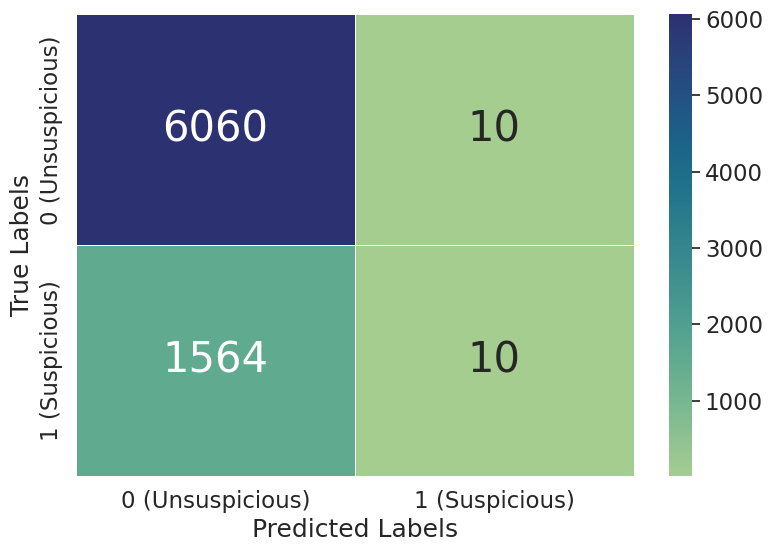

In [ ]:
# plot and store confusion matrix
df_cm=pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize=(9, 6))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True, fmt="d", cmap='crest', linewidth=.5, annot_kws={'size': 30}) # annot: if True, write the data value in each cell
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("confusion_matrix.png")

## Draw accuracy and loss

In [ ]:
def show_accuracy_history(train_acc_history, valid_acc_history, test_acc_history):
    plt.plot(train_acc_history)
    plt.plot(valid_acc_history)
    plt.plot(test_acc_history)
    plt.title('Train History', fontsize=20)
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['train', 'valid', 'test'], loc='upper left')
    plt.show()

def show_loss_history(loss_history):
    plt.plot(loss_history)
    plt.title('Train History', fontsize=20)
    plt.ylabel('loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['train'], loc='upper right')
    plt.show()

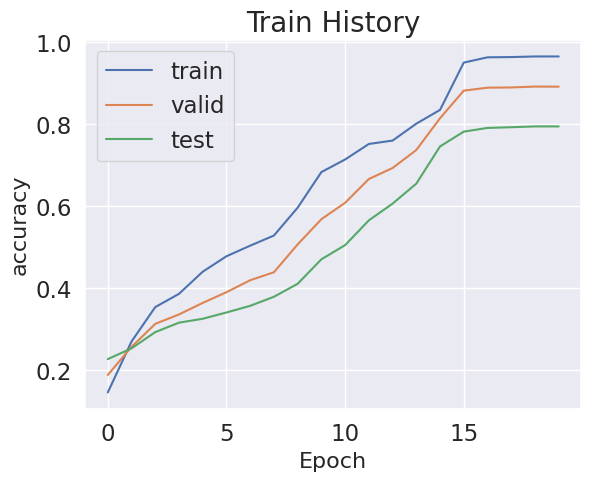

In [ ]:
show_accuracy_history(train_acc_history, valid_acc_history, test_acc_history)

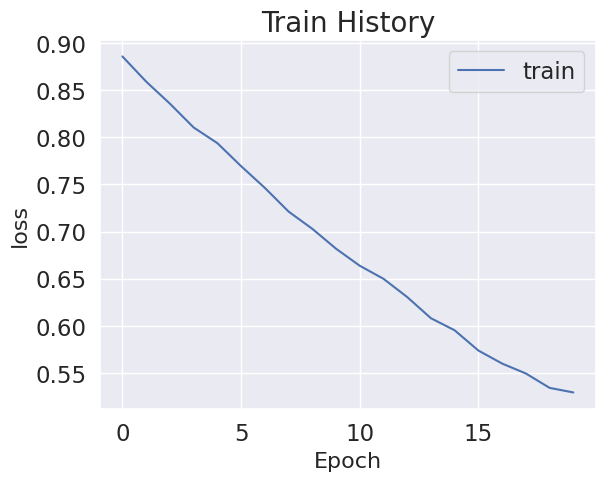

In [ ]:
show_loss_history(loss_history)

## Draw ROC curve

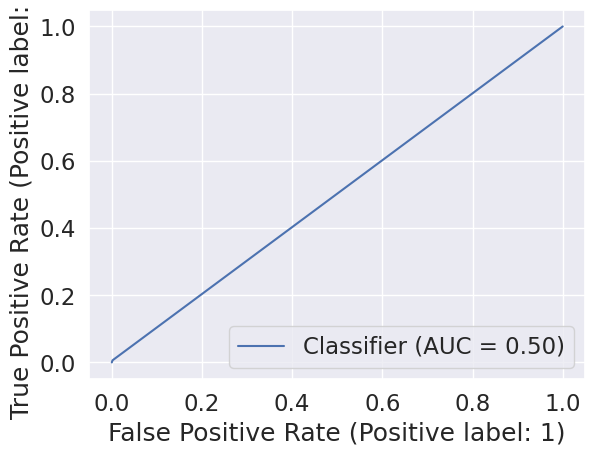

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_true, y_pred)
plt.show()